**LSTM - Trainign and Testing**

For LSTM parameters we took into considerations results and recommendations from [LSTM for Text Classification in Python](https://www.analyticsvidhya.com/blog/2021/06/lstm-for-text-classification/), [Binary LSTM model for text classification](https://pythonawesome.com/binary-lstm-model-for-text-classification/) and [Choose optimal number of epochs to train a neural network in Keras](https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/#:~:text=Therefore%2C%20the%20optimal%20number%20of,values%20against%20number%20of%20epochs.)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sn
import tensorflow as tf
from keras import callbacks
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, LSTM, Activation

**Read datasets**

In [ ]:
#the dataset is already padded and saved in g-drive from data preparation notebook

with open('/content/drive/MyDrive/MasterThesis/Dataset/train_padded', 'rb') as f:
    train_padded = pickle.load(f)
    
with open('/content/drive/MyDrive/MasterThesis/Dataset/test_padded', 'rb') as f:
    test_padded = pickle.load(f)    

In [ ]:
train_labels = pd.read_csv('/content/drive/MyDrive/MasterThesis/Dataset/y_train_all.csv')
test_labels =  pd.read_csv('/content/drive/MyDrive/MasterThesis/Dataset/y_test_all.csv')
y_train = train_labels.rate
y_test = test_labels.rate

**LSTM**

In [ ]:
max_length = 50
max_features = 20646

In [ ]:
#Building LSTM
inputs = Input(shape=(max_length,), dtype=tf.int32)
embeddings = Embedding(max_features, 100)(inputs)
out = LSTM(128, dropout=0.1)(embeddings)
outputs = Dense(1, activation="sigmoid")(out)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 100)           2064600   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,181,977
Trainable params: 2,181,977
Non-trainable params: 0
_________________________________________________________________


**Choosing batch_size and epoch numbers**

In this part we will try to choose the best batch size and number of epochs for which we have the best accuracy, without overfitting. We will be using a batch size of 32, as smaller sires generalize better. And to find the best combination with number of epoch, we will assign eppoch to 25 and use EarlyStoping() function to stop the training in the moment when the model starts overfitting.

In [ ]:
#patience = 5 --> wait until five epochs to see if the results are improving
#restore_best_weights ---> despite number of epochs including in the training, reset the weights from the best one for the model.
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, restore_best_weights = True)

In [ ]:
#batch_size = 32
history = model.fit(train_padded, y_train, batch_size=32, epochs=25, validation_split=0.1, callbacks =[earlystopping])

#save results
with open('/content/drive/MyDrive/MasterThesis/Dataset/LSTM_epoch_batch/batch_32', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Epoch 1/25
460/460 [==============================] - 68s 136ms/step - loss: 0.3390 - accuracy: 0.8463 - val_loss: 0.2327 - val_accuracy: 0.9064
Epoch 2/25
460/460 [==============================] - 46s 101ms/step - loss: 0.1439 - accuracy: 0.9518 - val_loss: 0.2704 - val_accuracy: 0.8960
Epoch 3/25
460/460 [==============================] - 49s 107ms/step - loss: 0.0872 - accuracy: 0.9747 - val_loss: 0.2798 - val_accuracy: 0.8874
Epoch 4/25
460/460 [==============================] - 46s 100ms/step - loss: 0.0621 - accuracy: 0.9824 - val_loss: 0.4334 - val_accuracy: 0.8758
Epoch 5/25
460/460 [==============================] - 46s 101ms/step - loss: 0.0456 - accuracy: 0.9875 - val_loss: 0.4568 - val_accuracy: 0.8825
Epoch 6/25
460/460 [==============================] - 46s 100ms/step - loss: 0.0402 - accuracy: 0.9893 - val_loss: 0.4111 - val_accuracy: 0.8905


**Testing**

In [ ]:
predictions = model.predict(test_padded) 

In [ ]:
with open('/content/drive/MyDrive/MasterThesis/Dataset/lstm_pred_propab', 'wb') as f:
    pickle.dump(predictions, f)   

In [ ]:
flat_pred = np.concatenate( predictions, axis=0 )
y_pred = []
for pred in flat_pred:
    y_pred.append(round(pred))

In [ ]:
with open('/content/drive/MyDrive/MasterThesis/Dataset/lstm_pred_flat', 'wb') as f:
    pickle.dump(y_pred, f)   

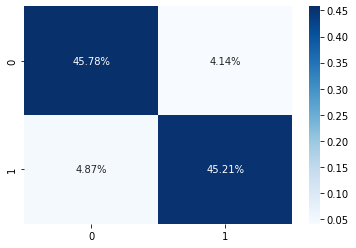

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sn.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
print (metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2038
           1       0.92      0.90      0.91      2045

    accuracy                           0.91      4083
   macro avg       0.91      0.91      0.91      4083
weighted avg       0.91      0.91      0.91      4083



In [ ]:
from keras.models import load_model
model.save('/content/drive/MyDrive/MasterThesis/LSTM/lstm.h5')

In [ ]:
with open('/content/drive/MyDrive/MasterThesis/Dataset/lstm_pred', 'wb') as f:
    pickle.dump(y_pred, f)    